In [1]:
import cv2
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# data process

In [2]:
maze_image = cv2.imread('maze.jpg')
maze = cv2.cvtColor(maze_image, cv2.COLOR_BGR2GRAY)

In [3]:
maze.shape

(480, 620)

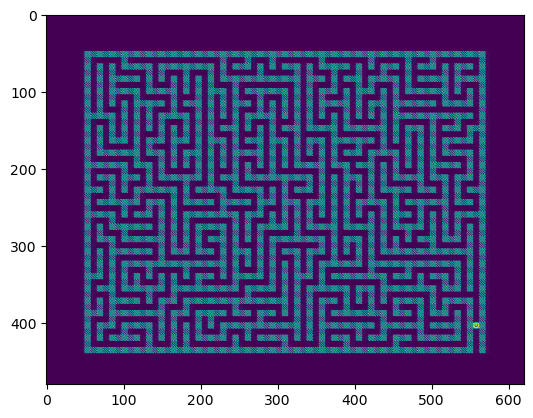

In [4]:
plt.imshow(maze)

In [5]:
import pandas as pd
result = pd.value_counts(maze.flatten())
result

0      178357
1        4869
13       4627
6        4370
12       4306
        ...  
210         1
179         1
195         1
197         1
194         1
Length: 92, dtype: int64

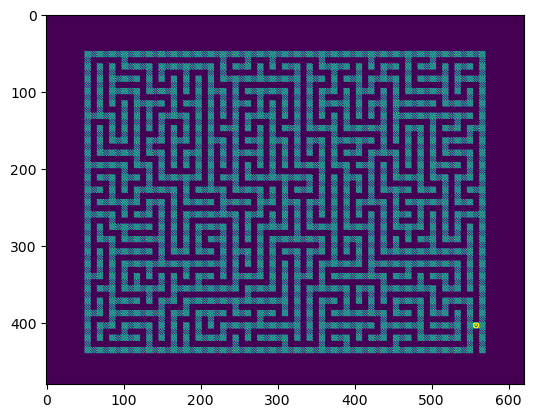

In [6]:
maze3 = maze.copy()
maze3[maze3 < 80] = 0
maze3[maze3 >= 80] = 255
plt.imshow(maze3)

In [7]:
mask = np.where(maze3 != 0)
up1, down1, up2, down2 = np.max(mask[0]), np.min(mask[0]), np.max(mask[1]), np.min(mask[1])

In [8]:
up1, up2, down1, down2

(439, 569, 48, 50)

In [9]:
l1 = (up1 - down1 + 1) // 8
l2 = (up2 - down2 + 1) // 8

In [10]:
l1, l2

(49, 65)

In [11]:
maze_shape = np.array([l1, l2])

In [12]:
maze_array = np.zeros(maze_shape)
for i in range(49):
    for j in range(65):
        pixes = maze3[48+i*8: 48+i*8+8, 50+j*8: 50+j*8+8]
        pix_ave = np.mean(pixes)
        maze_array[i, j] = pix_ave

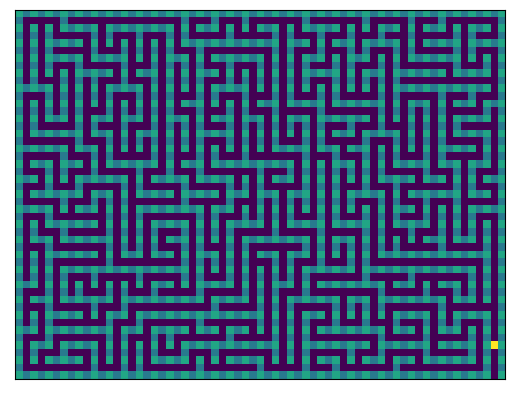

In [13]:
plt.imshow(maze_array)
plt.xticks([])
plt.yticks([])
plt.show()

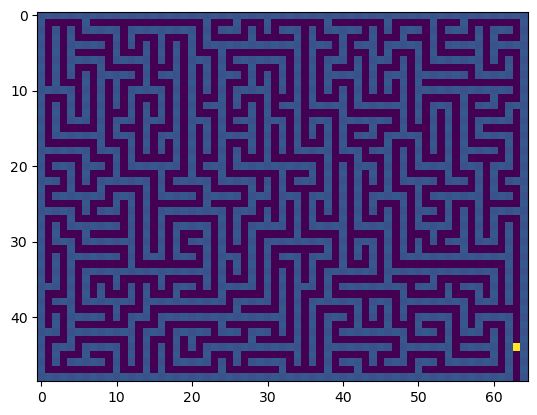

In [22]:
values = pd.value_counts(maze_array.flatten()).keys()
maze_array[maze_array == values[1]] = 1
maze_array[maze_array == values[2]] = 1.1
maze_array[maze_array == values[3]] = 4
plt.imshow(maze_array)
plt.savefig('maze_array.png', dpi=300)

# Q-learning

## utils

In [15]:
def sub2ind(rows, cols):
    array_shape = maze_shape
    return rows*array_shape[1] + cols

def ind2sub(ind):
    array_shape = maze_shape
    ind = np.asarray(ind)
    assert np.logical_and(0 <= ind, ind < array_shape[0] * array_shape[1]).all(), "{} is out of the maze".format(ind)
    rows = (ind.astype('int') // array_shape[1])
    cols = (ind.astype('int') % array_shape[1])
    return (rows, cols)

def step(location, direction):
    diff = np.array([[0, 1, 0, -1],
                     [-1, 0, 1, 0]], dtype=int)
    location += diff[:, direction]
    # assert location.min() >= 0, "{} is out of the maze".format(location)
    return location  

In [16]:
class MazeWalker:
    def __init__(self, tab_Q, start, epsilon=0.1, lr=0.5, gamma=0.9):
        self.tab_Q = tab_Q
        self.start = sub2ind(start[0], start[1])
        self.end = sub2ind(1, 1)
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma
        
    def update_end(self, end=None):
        if end is None:
            possible_end = np.where(self.tab_Q.max(axis=1) >= 0)[0]
            end = np.random.choice(possible_end)
        self.end = end
        return end
        
    def one_step(self, current, explore=False):
        if explore:
            rdn = np.random.rand()
        if explore and rdn < self.epsilon:
            # if explore, try directions that not points to the wall
            possible_direction = np.where(self.tab_Q[current, :] >= 0)[0]
        else:
            possible_direction = np.where(self.tab_Q[current, :] == self.tab_Q[current, :].max())[0]
        action = np.random.choice(possible_direction)
        
        cur_sub = ind2sub(current)
        next_sub = step(cur_sub, action)
        next_ind = sub2ind(next_sub[0], next_sub[1])
        
        if next_ind == self.start:
            reward = 10
            done = 1
        else:
            reward = 0
            done = 0
        
        if next_ind > self.tab_Q.shape[0] or next_ind < 0:
            done = 1
            next_ind = current
        elif self.tab_Q[next_ind, :].max() < 0:
            done = 1
            reward = -1

        return action, next_ind, reward, done
    
    def one_episode(self, train=True, end=1408, explore=False):
        location = self.update_end(end)
        location_list = [location]
        done = 0
        itr = 0
        max_itr = 5000
        while not done:
            if itr > max_itr:
                break
            itr += 1
            action, next_location, reward, done= self.one_step(location, explore=explore)
            if train:
                self.tab_Q[location, action] += self.lr * (reward + self.gamma * np.max(self.tab_Q[next_location]) - self.tab_Q[location, action])
            location = next_location
            location_list.append(location)
        return location_list, reward
    
    def train(self, episodes, end=1408, explore=False):
        success = 0
        t_begin = time.time()
        t1 = t_begin
        for i in range(episodes):
            _, reward = self.one_episode(train=True, end=end, explore=explore)
            if reward >0 :
                reward = 1
            else:
                reward = 0
            success += reward # if succeed, += 1, else += 0
            if i % 100 == 0:
                t2 = time.time()
                print(f"episode {i}, success {success}%, total {t2 - t_begin}s, last epoch {t2 - t1}s")
                t1 = t2
                success = 0
                

In [17]:
rows, cols = np.where(np.logical_and(maze_array > 0, maze_array < 4))
wall_inds = sub2ind(rows, cols)

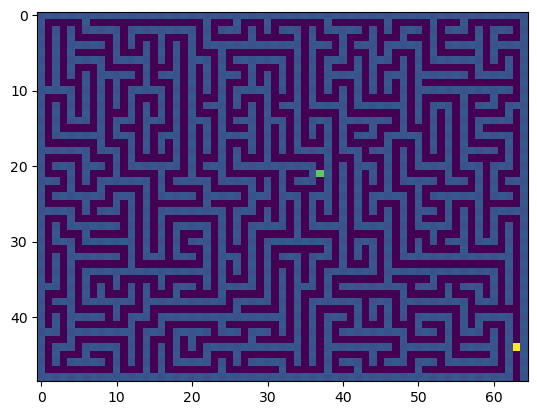

In [18]:
kkk = maze_array.copy()
# kkk[rows, cols] = 3
kkk[21,37] = 3
plt.imshow(kkk)

In [19]:
tab_Q = np.zeros([len(maze_array.flatten()), 4])
rows, cols = np.where(np.logical_and(maze_array > 0, maze_array < 4))
wall_inds = sub2ind(rows, cols)
tab_Q[wall_inds, :] = -1
start = np.where(maze_array == np.max(maze_array))
walker = MazeWalker(tab_Q, start, epsilon=0.1, lr=0.8, gamma=0.8)

In [20]:
for i in range(1):
    walker.train(20000, end=None, explore=True)
    # tab_Q_visual = tab_Q.max(axis=1).reshape(maze_shape)
    # plt.imshow(tab_Q_visual)
    # plt.colorbar()
    # plt.show()

episode 0, success 0%, total 0.0009982585906982422s, last epoch 0.0009982585906982422s
episode 100, success 0%, total 0.029920578002929688s, last epoch 0.028922319412231445s
episode 200, success 0%, total 0.0718085765838623s, last epoch 0.04188799858093262s
episode 300, success 0%, total 0.12079071998596191s, last epoch 0.04898214340209961s
episode 400, success 0%, total 0.1513373851776123s, last epoch 0.03054666519165039s
episode 500, success 0%, total 0.1832585334777832s, last epoch 0.0319211483001709s
episode 600, success 0%, total 0.2161405086517334s, last epoch 0.032881975173950195s
episode 700, success 0%, total 0.25307321548461914s, last epoch 0.03693270683288574s
episode 800, success 0%, total 0.2847609519958496s, last epoch 0.03168773651123047s
episode 900, success 0%, total 0.31866908073425293s, last epoch 0.03390812873840332s
episode 1000, success 0%, total 0.35361742973327637s, last epoch 0.03494834899902344s
episode 1100, success 0%, total 0.3895120620727539s, last epoch 0

In [21]:
for i in range(1):
    walker.train(5000, end=None, explore=False)

episode 0, success 1%, total 0.011968135833740234s, last epoch 0.011968135833740234s
episode 100, success 100%, total 2.22360897064209s, last epoch 2.2116408348083496s
episode 200, success 100%, total 4.275613784790039s, last epoch 2.052004814147949s
episode 300, success 100%, total 6.062772989273071s, last epoch 1.7871592044830322s
episode 400, success 100%, total 8.28164553642273s, last epoch 2.218872547149658s
episode 500, success 100%, total 10.635684967041016s, last epoch 2.354039430618286s
episode 600, success 100%, total 13.055269479751587s, last epoch 2.4195845127105713s
episode 700, success 100%, total 15.282085418701172s, last epoch 2.226815938949585s
episode 800, success 100%, total 17.16210389137268s, last epoch 1.8800184726715088s
episode 900, success 100%, total 19.260749340057373s, last epoch 2.0986454486846924s
episode 1000, success 100%, total 21.1044282913208s, last epoch 1.8436789512634277s
episode 1100, success 100%, total 22.908332347869873s, last epoch 1.803904056

In [361]:
np.unique(tab_Q)

array([-1.        , -0.95      ,  0.        , ...,  1.89290711,
        1.91446725,  2.10323012])

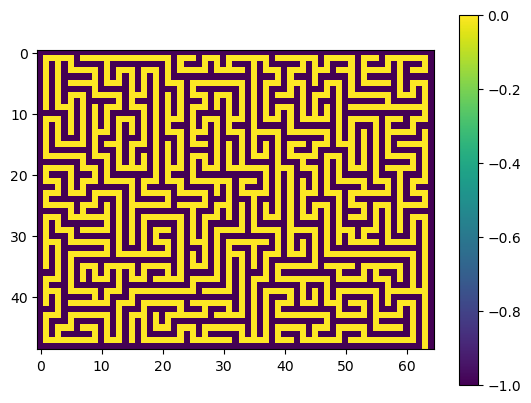

In [267]:
tab_Q_visual = tab_Q.max(axis=1).reshape(maze_shape)
plt.imshow(tab_Q_visual)
plt.colorbar()

In [41]:
location_list, _ = walker.one_episode(train=False, end=None)

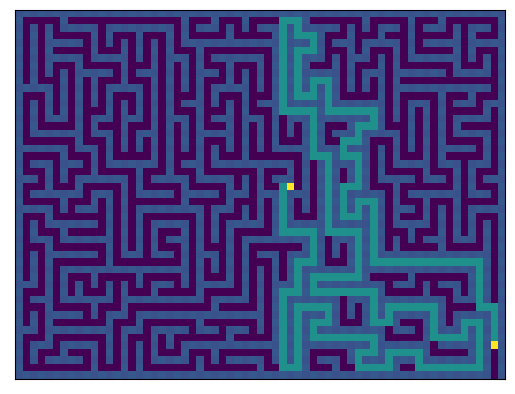

In [42]:
rows, cols = ind2sub(np.asarray(location_list[1:-1]))
kkk = maze_array.copy()
row_end, col_end = ind2sub(np.asarray(location_list[0]))
kkk[rows, cols] = 2
kkk[row_end, col_end] = 4
plt.imshow(kkk)
plt.xticks([])
plt.yticks([])
plt.savefig('wgc3.png', dpi=300)

In [160]:
ind2sub(67)

(1, 2)

In [ ]:
1408, 1412, 1422, 1424, 1404

In [363]:
np.savetxt('tab_Q.txt', tab_Q)